# Lab05 - Tipos de Redes Neuronales

En la sesion pasada creamos nuestra primera **Red Neuronal Profunda** usando capas densas (*Fully Connected*) ya que se trataba de una regresion lineal sencilla.  

Ahora, vamos a crear una **Red Neuronal Convolucional** en un problema muy comun de Inteligencia Artificial: Clasificacion de imagenes! 

Trate de instalar estas librerias y de cargarlas en su ambiente de trabajo.  Si se encuentra algun error siempre puede trabajar en el ambiente virtual de Docker.

In [1]:
library(tidyr)
library(ggplot2)
library(keras)
library(imager)

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following object is masked from ‘package:tidyr’:

    fill


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




## Cargar el set de datos

Dependiendo del problema que queramos solucionar, va a ser necesario recolectar una gran cantidad de imagenes para entrenar el modelo.  Existen fuentes de datos abiertas para casos de uso generales como: personas, animales, flores, automoviles, etc.  
Por otro lado, cuando nuestro problema es mucho mas particular y no se encuentran datasets ya creados para nuestro caso, sera necesario recolectar las imagenes manualmente.  La regla siempre sera: *Entre mas imagenes, mejor*.  
En cualquiera de los dos casos, la estructura recomendable para organizar las imagenes es la siguiente:
```
Directorio Raiz
|--- /train
|   |---- /clase1
|   |    ---- /imagen01.jpg
|   |    ---- /imagen02.jpg
|   |    ---- /...
|   |---- /clase2
|   |    ---- /imagen01.jpg
|   |    ---- /imagen02.jpg
|   |    ---- /...
|   |---- /...
|   
|--- /test
|   |---- /clase1
|   |    ---- /imagen01.jpg
|   |    ---- /imagen02.jpg
|   |    ---- /...
|   |---- /clase2
|   |    ---- /imagen01.jpg
|   |    ---- /imagen02.jpg
|   |    ---- /...
|   |---- /...
```

Los directorios no *necesariamante* deben llamarse asi, pero si es recomendable tener un set de datos de entrenamiento separado del de pruebas.  Ademas, los **nombres** de las carpetas dentro de estos (clase1, clase2, ...), son los que indicaran las **clases/labels** de las imagenes que estan adentro.

Vamos a trabajar con un dataset de Logos de algunas empresas conocidas, se puede descargar de [aqui](http://flovv.github.io/Logo_detection_deep_learning/), pero para facilidad ya se encuentra descargado y  organizado en la estructura necesaria dentro de nuestra carpeta */data*:
![Logos_sample](http://flovv.github.io/figures/post21/flickr27-sample.png)

El dataset consta de 675 imagenes de 27 marcas diferentes (En promedio 25 imagenes de cada clase para entrenamiento y pruebas).  En un problema real esto es un dataset pequeno, pero hoy nos servira para aprender otros conceptos de Redes Neuronales.

In [2]:
img_width <- 32
img_height <- 32
train_samples <- 498
validation_samples <- 177
classes <- c('Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 
             'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'Intel', 'McDonalds', 
             'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 
             'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo')

train_directory <- "LogoData/train"
test_directory <- "LogoData/test"

In [3]:
# Configuracion de Hiperparametros:
batch_size <- 8
learning_rate <- 0.0001
epochs <- 50

### Data Augmentation

Como ya se ha mencionado varias veces, entre mas datos tengamos, mejor.  En el caso de Computer Vision: entre mas imagenes, mejor.
Cuando no tenemos suficientes datos, la tecnica de Data Augmentation permite, por medio de un algoritmo, generar imagenes artificialmente a partir de las pocas imagenes que tenemos.  Esto se logra haciendo cambios pequenos a los datos: Girar un poco la imagen, cambiando su luminocidad, resolucion, moviendola un poco, etc.  Para nosotros es un cambio pequeno, pero para el modelo es una imagen completamente diferente!
![Data Augmenation](https://miro.medium.com/max/605/0*Utma-dS47hSoQ6Zt)  
A nivel de codigo, estas son TODAS las opciones que se pueden configurar para el generador de datos, tenga en cuenta que no siempre todas aplican, por ejemplo, la imagen del leon mirando a la derecha o mirando a la izquierda, sigue siendo un leon, pero, nuestros logos?

In [4]:
# Estas son TODAS las opciones!
datagen <- image_data_generator(
  featurewise_center = FALSE,
  samplewise_center = FALSE,
  featurewise_std_normalization = FALSE,
  samplewise_std_normalization = FALSE,
  zca_whitening = FALSE,
  zca_epsilon = 1e-06,
  rotation_range = 0,
  width_shift_range = 0,
  height_shift_range = 0,
  brightness_range = NULL,
  shear_range = 0,
  zoom_range = 0,
  channel_shift_range = 0,
  fill_mode = "nearest",
  cval = 0,
  horizontal_flip = FALSE,
  vertical_flip = FALSE,
  rescale = NULL
)

In [5]:
train_generator <- flow_images_from_directory(train_directory, generator = datagen,
                                              target_size = c(img_width, img_height), color_mode = "rgb",
                                              class_mode = "categorical", batch_size = batch_size, shuffle = TRUE,
                                              seed = 123)

validation_generator <- flow_images_from_directory(test_directory, generator = datagen,
                                                   target_size = c(img_width, img_height), color_mode = "rgb", classes = NULL,
                                                   class_mode = "categorical", batch_size = batch_size, shuffle = TRUE,
                                                   seed = 123)

Hemos creado dos generadores de imagenes porque cada dataset partira de un directorio diferente, y puede ser con transformaciones diferentes.  
Ahora si, podemos crear el modelo:

In [6]:
model <- keras_model_sequential()

model %>%
  layer_conv_2d(filter = 16, kernel_size = c(3,3), input_shape = c(img_width, img_height, 3)) %>%
  layer_activation("relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>% 
  
  layer_conv_2d(filter = 32, kernel_size = c(3,3)) %>%
  layer_activation("relu") %>%
  layer_max_pooling_2d(pool_size = c(2,2)) %>%
  
  layer_flatten() %>%
  layer_dense(64) %>%
  layer_activation("relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(27) %>%    ## we have 27 brand logo classes!
  layer_activation("softmax")

summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 30, 30, 16)              448         
________________________________________________________________________________
activation (Activation)             (None, 30, 30, 16)              0           
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 15, 15, 16)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 13, 13, 32)              4640        
________________________________________________________________________________
activation_1 (Activation)           (None, 13, 13, 32)              0           
________________________________________________________________________________
max_pool

En el resumen que nos entrega el modelo podemos ver:

- Estructura de la red, capa por capa
- Como van disminuyendo las dimensiones de cada capa, empezando por las dimensiones de la imagen (30,30) hasta la ultima capa = Numero de clases (27)
- Cantidad de parametros que se van a calcular/entrenar: 80.635

In [7]:
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_rmsprop(lr = 0.0001, decay = 1e-6),
  metrics = "accuracy"
)

In [8]:
hist <- model %>% fit_generator(
  train_generator,
  steps_per_epoch = as.integer(train_samples/batch_size), 
  epochs = epochs, 
  validation_data = validation_generator,
  validation_steps = as.integer(validation_samples/batch_size),
  verbose=2
)

`geom_smooth()` using formula 'y ~ x'



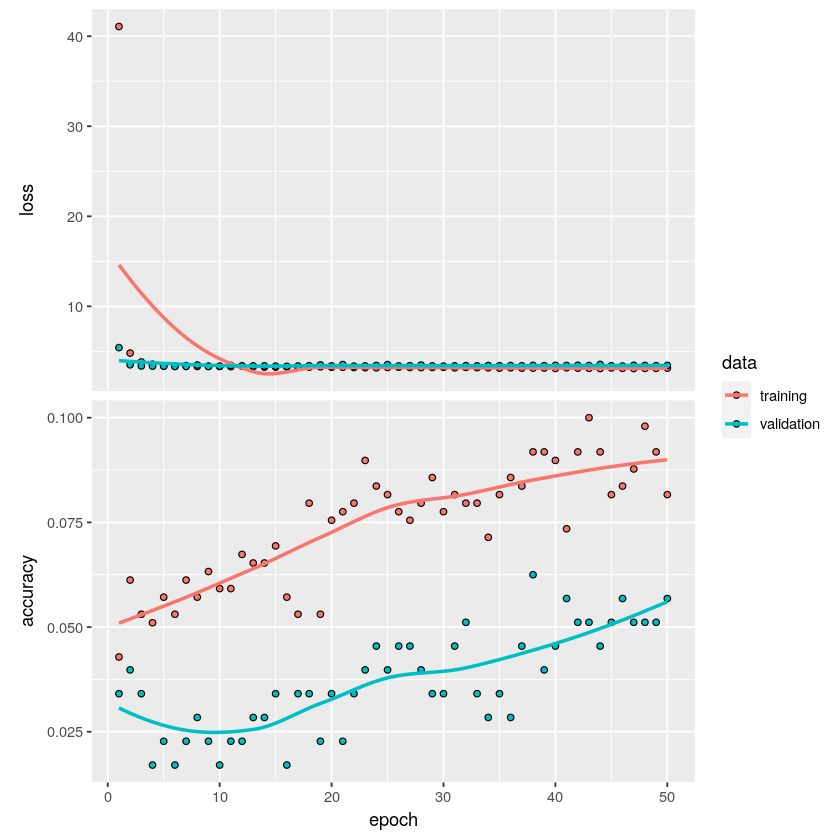

In [9]:
plot(hist)

En la grafica de **loss** podemos ver como va disminuyendo nuestro *categorical_crossentropy* en cada epoca.  
Tambien podemos ver los valores finales del loss y el accuracy:

In [10]:
evaluate_generator(model,validation_generator, validation_samples)

loss   accuracy 
3.43935966 0.05649718

Una vez aprobemos nuestro modelo, podemos usarlo para predecir sobre imagenes nuevas:

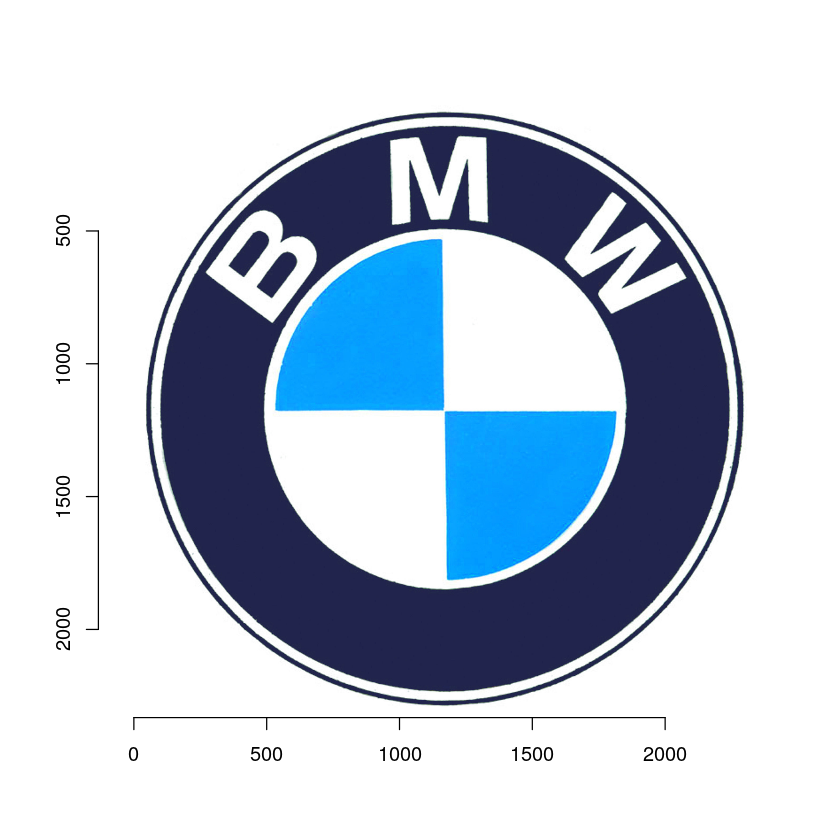

In [11]:
img_path  <- "https://i.pinimg.com/originals/07/0d/3e/070d3e118fa9bcf14bf6a1004308c91b.jpg"
download.file(img_path,'test.jpg', mode = 'wb')
plot(load.image('test.jpg'))

In [12]:
img <- image_load('test.jpg', target_size = c(img_width,img_height))
x <- image_to_array(img)
dim(x) <- c(1, dim(x)) 
prediction <- model %>% predict(x)
prediction

2.151891e-14,3.840677e-15,0.999606,8.999947e-15,2.704429e-15,5.821742e-07,9.132937e-07,1.818655e-23,1.001873e-13,1.324622e-11,⋯,0.0001242633,5.735077e-20,1.231938e-19,7.789809e-09,1.488678e-20,5.43312e-18,4.067727e-19,1.644006e-06,1.357738e-21,1.253839e-08


El resultado de la prediccion es la salida de la ultima neurona, es decir 27 valores que siginifican la probabilidad de que la imagen dada pertenesca a cada una de las 27 clases objetivo.

In [13]:
dim(prediction)

[1]  1 27

Para saber, entonces, la clase que indica la prediccion basta con elegir la probabilidad mas alta del vector entregado, pues corresponden, por indice a las clases objetivo:

In [14]:
classes[which.max(prediction)]

[1] "BMW"

**Taller:**  

El modelo puede mejorar, no solo porque hizo una prediccion correcta, el loss aun esta un poco alto, y el accuracy esta muy bajo.  Ademas, el valor de *accuracy* para el set de entrenamiento fue mas alto que el de pruebas, quiere decir que el modelo esta aprendiendo de memoria casos particulres, en lugar de patrones generales (Overfit).  Para ello:

- Juegue un poco con los hiperparametros, capas y funciones de activacion para mejorar estos valores.  Para ello peude usar la documentacion de [keras](https://keras.rstudio.com/reference/index.html)
- Busque otra imagen (*.jpg*) de alguno de los logos en nuestro modelo y haga la prediccion.  Funciona? Estamos safisfechos con este modelo? Podria mejorar?  


## 5b. Transfer Learning  
Para no tener que disenar la red desde ceros, pensando que capas, neuronas y funciones de activacion usar, usamos Transfer Learning, en el que tomamos la estructura de una red ya contruida y especializada en una tarea especifica (Ej: Reconocimiento de imagen).  
Los siguientes pasos iniciales siguen siendo necesarios: 
- Definicion de hiperprametros
- Generador de imagenes nuevas (Data Augemtnation)
- Configuracion de generadores para entrenamiento y pruebas  

Pero en lugar de crear un modelo desde ceros, vamos a tomar un modelo ya existente, por ejemplo VGG16 y vamos a indicar que sus capas NO SON reentrenables:

In [15]:
base_model <- application_vgg16(weights = 'imagenet', include_top = FALSE)

for (layer in base_model$layers)
  layer$trainable <- FALSE

summary(base_model)

Model: "vgg16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, None, None, 3)]         0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, None, None, 64)          1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, None, None, 64)          36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, None, None, 64)          0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, None, None, 128)         73856       
________________________________________________________________________________
block2_conv2 

Vemos la estructura tan compleja que tiene esta red ya preentrenada, mas de 14.5 millones de parametros!  En este caso, tambien hemos indicado que este modelo no sea reentrenable.  
Tambien hemos indicado al modelo no incluir la "cabeza" de la red, pues las ultimas capas las vamos a reescribir nosotros mismos:

In [16]:
model_head <- base_model$output %>% 
  layer_global_average_pooling_2d(trainable = T) %>% 
  layer_dense(64, trainable = T) %>%
  layer_activation("relu", trainable = T) %>%
  layer_dropout(0.4, trainable = T) %>%
  layer_dense(27, trainable=T) %>%    ## important to adapt to fit the 27 classes in the dataset!
  layer_activation("softmax", trainable=T)

my_model <- keras_model(inputs = base_model$input, outputs = model_head)

In [17]:
summary(my_model)

Model: "model"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, None, None, 3)]         0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, None, None, 64)          1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, None, None, 64)          36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, None, None, 64)          0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, None, None, 128)         73856       
________________________________________________________________________________
block2_conv2 

Vemos ahora que, la estructura de nuestra nueva red es mucho mas compleja, incluye los 14.5 millones de parametros del modelo VGG16, adicionalmente hemos configurado la capa de entrada para que reciba las imagenes que tenemos preparadas, pero lo mas importante, hemos configurado algunas capas adicionales como la **nueva cabeza** de la red.  
Al final del resumen vemos que, los 14.5 millones de parametros del modelo base (VGG16) no son entrenables, pero los 34mil de nuestra nueva cabeza si, y estos son los valores que va a buscar el modelo.  

Hemos creado en pocas lineas un modelo mas complejo, pero mas sencillo de entrenar.  Desde aqui la compilacion y entrenamiento del modelo es igual a como ya lo hemos trabajado:

In [18]:
my_model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_rmsprop(lr = learning_rate, decay = 1e-6),
  metrics = "accuracy"
)

Como paso adicional de este laboratorio vamos a trabajar con los Callbacks que vimos la sesion pasada.  Son funciones que se ejecutan al final de cada epoca y que pueden ayudar a mejorar el rendimiento del modelo:

In [19]:
mis_callbacks = list(
  # Modificar el LR si el modelo no mejora:
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.1, patience=5),
  # Configurar que el modelo pare si no mejora:
  callback_early_stopping(monitor="val_accuracy",patience=10,mode="auto"),
  # Ir guardando el mejor modelo
  callback_model_checkpoint("models/logos_checkpoints.h5", monitor="val_loss", save_best_only = TRUE)
)

In [ ]:
hist <- my_model %>% fit_generator(
  train_generator,
  steps_per_epoch = as.integer(train_samples/batch_size), 
  epochs = epochs, 
  validation_data = validation_generator,
  validation_steps = as.integer(validation_samples/batch_size),
  verbose=2,
  callbacks = mis_callbacks
)

plot(hist)

In [ ]:
evaluate_generator(my_model,validation_generator,
                   steps=as.integer(validation_samples/batch_size))

En comparacion con nuestro modelo inicial (*Loss = 2.46, Accuracy=0.26*), este modelo da mejores resultados!  
Vamos ahora a probarlo con imagenes nuevas:

In [ ]:
img_path  <- "https://i.pinimg.com/originals/02/ac/cd/02accd95989df4cde2f57adcd508dbcd.jpg"
download.file(img_path,'test.jpg', mode = 'wb')
plot(load.image('test.jpg'))

In [ ]:
img <- image_load('test.jpg', target_size = c(img_width,img_height))
x <- image_to_array(img)
dim(x) <- c(1, dim(x)) 
prediction <- model %>% predict(x)
prediction

In [ ]:
classes[which.max(prediction)]

**Taller**  

**Ups!** Al modelo le falta un poco de afinamiento, intente:

- Cambiar el modelo base VGG16 por otros modelos como *VGG19, ResNet50, InceptionV3, MobileNet, Xception*.  Para ello peude usar la documentacion de [keras](https://keras.rstudio.com/reference/index.html)
- Juegue un poco con los hiperparametros, capas y funciones de activacion en la **cabeza de la red** para mejorar los valores de loss, accuracy y las predicciones.
- Busque otra imagen (*.jpg*) de alguno de los logos en nuestro modelo y haga la prediccion.  Funciona? Estamos safisfechos con este modelo? Podria mejorar?